**Author**: Vo Thien Hai Le (Seannie Le)

**Email**: seanniele@gmail.com

In [1]:
import pandas as pd
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Dynamically handle small values that cause 'divide by zero' in matrix math
np.seterr(divide='ignore', invalid='ignore', over='ignore')

# --- Scikit-learn ---
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics 

# Import ML Models
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR 
import xgboost as xgb 

import plotly.express as px
import plotly.graph_objects as go

# --- Plotting Configuration ---
import matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (11, 6)
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "Times New Roman"
%matplotlib inline


In [2]:
# --- Data Loading ---
fpath_merged = '../datasets/processed/base_df.csv'
df_model = pd.read_csv(fpath_merged)
print(f"Successfully loaded {fpath_merged}!")
    
int_cols = ['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'nsmiles', 'passengers']
for col in int_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce').astype('Int64')
    
if 'period' not in df_model.columns and 'Year' in df_model.columns and 'quarter' in df_model.columns:
    df_model['period'] = df_model['Year'].astype(str) + '-Q' + df_model['quarter'].astype(str)
if 'lg_carrier_is_lcc' not in df_model.columns and 'carrier_lg' in df_model.columns:
    lcc_codes = ['WN', 'NK', 'B6', 'F9', 'G4'] # ensure this list is correct
    df_model['lg_carrier_is_lcc'] = df_model['carrier_lg'].isin(lcc_codes).astype(int)

Successfully loaded ../datasets/processed/base_df.csv!


In [3]:
skewed_cols = ['passengers', 'fare']
for col in skewed_cols:
    df_model[f'log_{col}'] = np.log1p(df_model[col].astype(float))
    print(f"Created log-transformed column: 'log_{col}'")

Created log-transformed column: 'log_passengers'
Created log-transformed column: 'log_fare'


In [4]:
# Create Interaction Terms 
# Based on EDA/Hypothesis, e.g., does fare effect depend on LCC presence?
print("\nCreating Interaction Term (fare * lg_carrier_is_lcc)...")
df_model['fare_x_is_lcc'] = df_model['fare'] * df_model['lg_carrier_is_lcc']


Creating Interaction Term (fare * lg_carrier_is_lcc)...


In [5]:
# Target for Prediction Model
TARGET_PREDICTION = 'log_passengers'

# Features for Prediction Model (X_pred) - include treatment and potential confounders/predictors
FEATURES_PREDICTION = [
    'log_fare', # include treatment variable as a predictor
    # 'fare',
    'nsmiles',
    'large_ms',
    'lf_ms',
    'origin_fare_premium',
    'origin_perc_lcc_pax',
    'dest_fare_premium',
    'dest_perc_lcc_pax',
    'Year', # keep as numeric trend 
    'quarter', # keep as numeric 
    'lg_carrier_is_lcc', # binary
    'avg_fuel_price',
    'carrier_lg',
    'is_Q_with_NYD', 
    'is_Q_with_Memorial', 
    'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 
    'is_Q_with_Christmas', 
    'fare_x_is_lcc'
]

features_prediction = [f for f in FEATURES_PREDICTION if f in df_model.columns]

print(f"Target for Prediction: {TARGET_PREDICTION}")
print(f"Features for Prediction: {features_prediction}")

Target for Prediction: log_passengers
Features for Prediction: ['log_fare', 'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'quarter', 'lg_carrier_is_lcc', 'avg_fuel_price', 'carrier_lg', 'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Christmas', 'fare_x_is_lcc']


### One-Hot Encoding for `quarter` & `carrier_lg`

In [6]:
# `quarter`
print("\nApplying One-Hot Encoding for 'quarter'...")
quarter_dummy_cols = []
df_model['quarter'] = df_model['quarter'].astype('category')
quarter_dummies = pd.get_dummies(df_model['quarter'], prefix='Q', drop_first=True) # drop_first=True avoids multicollinearity
quarter_dummy_cols = quarter_dummies.columns.tolist()
df_model = pd.concat([df_model, quarter_dummies], axis=1)
df_model.drop('quarter', axis=1, inplace=True)
print(f"Created quarter dummies: {quarter_dummy_cols}")


Applying One-Hot Encoding for 'quarter'...
Created quarter dummies: ['Q_2', 'Q_3', 'Q_4']


In [7]:
# `carrier_lg``
print("\nApplying One-Hot Encoding for 'carrier_lg' (top 3)...")
top_3_carriers = df_model['carrier_lg'].value_counts().nlargest(3).index.tolist()
top_3_dummy_carriers = []
for c in top_3_carriers:
    dummy_col_name = f'carrier_{c}'
    # 1 if carrier_lg matches this top carrier, otherwise 0
    df_model[dummy_col_name] = np.where(df_model['carrier_lg'] == c, 1, 0)
    top_3_dummy_carriers.append(dummy_col_name)
    print(f"Created dummy column {dummy_col_name}!")

df_model.drop('carrier_lg', axis=1, inplace=True) # drop original column


Applying One-Hot Encoding for 'carrier_lg' (top 3)...
Created dummy column carrier_WN!
Created dummy column carrier_DL!
Created dummy column carrier_AA!


In [8]:
# Update feature lists if dummies are added
def update_feature_list(feature_list, old_col, new_cols):
    new_list = [f for f in feature_list if f != old_col] # remove old if exists
    for new_col in new_cols:
        if new_col not in new_list: # add new dummies if not already present
            new_list.append(new_col)
    return new_list

features_prediction = update_feature_list(features_prediction, 'quarter', quarter_dummy_cols)
features_prediction = update_feature_list(features_prediction, 'carrier_lg', top_3_dummy_carriers)

print("\n--- Updated Feature Lists After Dummies ---")
print(f"Features for Prediction: {features_prediction}")


--- Updated Feature Lists After Dummies ---
Features for Prediction: ['log_fare', 'nsmiles', 'large_ms', 'lf_ms', 'origin_fare_premium', 'origin_perc_lcc_pax', 'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'lg_carrier_is_lcc', 'avg_fuel_price', 'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 'is_Q_with_Labor', 'is_Q_with_Christmas', 'fare_x_is_lcc', 'Q_2', 'Q_3', 'Q_4', 'carrier_WN', 'carrier_DL', 'carrier_AA']


In [9]:
# Scaling Numerical Features (Setup - actual scaling happens AFTER train/test split)
# Identify numerical features needing scaling (excluding binary/dummy vars)

numerical_features_to_scale = [
    'log_fare', 'nsmiles', 'large_ms', 'lf_ms', 
    'origin_fare_premium', 'origin_perc_lcc_pax',
    'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'fare_x_is_lcc',
    'avg_fuel_price'
]
    
# Filter based on columns present in df_model
numerical_features_to_scale = sorted(list(set([f for f in numerical_features_to_scale if f in df_model.columns])))

print(f"\nNumerical features identified for scaling (will be done after split): {numerical_features_to_scale}")

# 4. Final Check
print("\n--- Final Processed DataFrame for Modeling (df_model) ---")
df_model.info()
print(df_model.head())


Numerical features identified for scaling (will be done after split): ['Year', 'avg_fuel_price', 'dest_fare_premium', 'dest_perc_lcc_pax', 'fare_x_is_lcc', 'large_ms', 'lf_ms', 'log_fare', 'nsmiles', 'origin_fare_premium', 'origin_perc_lcc_pax']

--- Final Processed DataFrame for Modeling (df_model) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  115032 non-null  Int64  
 1   citymarketid_1        115032 non-null  Int64  
 2   citymarketid_2        115032 non-null  Int64  
 3   city1                 115032 non-null  object 
 4   city2                 115032 non-null  object 
 5   nsmiles               115032 non-null  Int64  
 6   passengers            115032 non-null  Int64  
 7   fare                  115032 non-null  float64
 8   large_ms              115032 non-null  float64
 9   fare_l

In [10]:
# --- Save Processed Data ---
fpath_processed = '../datasets/processed/final_df.csv'
df_model.to_csv(fpath_processed, index=False)
print(f"Processed data saved to {fpath_processed}!")

Processed data saved to ../datasets/processed/final_df.csv!


In [11]:
bool_cols = ['Q_2', 'Q_3', 'Q_4', 
             'is_Q_with_NYD', 'is_Q_with_Memorial', 'is_Q_with_Jul4_Indep', 
             'is_Q_with_Labor', 'is_Q_with_Thx', 'is_Q_with_Christmas',
             'carrier_WN', 'carrier_DL', 'carrier_AA' , 'lg_carrier_is_lcc'] 
for col in bool_cols:
    if col in df_model.columns: 
        df_model[col] = df_model[col].astype(bool)
int_cols = ['passengers', 'Year', 'nsmiles'] 
for col in int_cols:
     if col in df_model.columns: df_model[col] = pd.to_numeric(df_model[col], errors='coerce').astype('Int64')
print("Loaded df_model info:")
df_model.info()

Loaded df_model info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115032 entries, 0 to 115031
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Year                  115032 non-null  Int64  
 1   citymarketid_1        115032 non-null  Int64  
 2   citymarketid_2        115032 non-null  Int64  
 3   city1                 115032 non-null  object 
 4   city2                 115032 non-null  object 
 5   nsmiles               115032 non-null  Int64  
 6   passengers            115032 non-null  Int64  
 7   fare                  115032 non-null  float64
 8   large_ms              115032 non-null  float64
 9   fare_lg               115032 non-null  float64
 10  carrier_low           115032 non-null  object 
 11  lf_ms                 115032 non-null  float64
 12  fare_low              115032 non-null  float64
 13  origin_fare_premium   115032 non-null  float64
 14  origin_perc_lcc_pax   115032 n

### 0. Helper Functions 

In [12]:
label_map = {
    'Year': 'Year',
    'quarter': 'Quarter',
    'citymarketid_1': 'Origin ID',
    'citymarketid_2': 'Dest. ID',
    'city1': 'Origin City',
    'city2': 'Dest. City',
    'nsmiles': 'Distance (Miles)',
    'passengers': 'Passengers',
    'fare': 'Fare ($)',
    'carrier_lg': 'Lead Carrier',
    'large_ms': 'Share (Lead)',
    'fare_lg': 'Fare (Lead)',
    'carrier_low': 'Low Carrier',
    'lf_ms': 'Share (Low)',
    'fare_low': 'Fare (Low)',
    'origin_fare_premium': 'Origin Premium',
    'origin_perc_lcc_pax': 'LCC Share (Origin)',
    'dest_fare_premium': 'Destination Premium',      
    'dest_perc_lcc_pax': 'LCC Share (Dest)',      
    'route_id': 'Route ID',               
    'avg_fuel_price': 'Fuel Price',         
    'is_Q_with_NYD': 'Quarter with New Year’s Day',          
    'is_Q_with_Memorial': 'Quarter with Memorial Day',     
    'is_Q_with_Jul4_Indep': 'Quarter with Independence Day',   
    'is_Q_with_Labor': 'Quarter with Labor Day',              
    'is_Q_with_Christmas': 'Quarter with Christmas',     
    'period': 'Period',                 
    'lg_carrier_is_lcc': 'LCC Flag',
    'Q_2': 'Q2',
    'Q_3': 'Q3',
    'Q_4': 'Q4',
    'carrier_WN': 'Southwest',
    'carrier_DL': 'Delta',
    'carrier_AA': 'American',
    'num__nsmiles': 'Distance (Miles)',
    'num__large_ms': 'Share (Lead)',
    'num__origin_perc_lcc_pax': 'LCC Share (Origin)',
    'num__fare': 'Fare ($)',
    'num__origin_fare_premium': 'Origin Premium',
    'num__dest_fare_premium': 'Destination Premium',
    'num__lf_ms': 'Share (Low)',
    'num__Year': 'Year',
    'num__dest_perc_lcc_pax': 'LCC Share (Dest)',
    'num__fare_x_is_lcc': 'Fare x LCC',
    'num__log_fare': 'Logarithm of Fare',
    'remainder__is_Q_with_NYD': 'Quarter with New Year’s Day',
    'remainder__is_Q_with_Memorial': 'Quarter with Memorial Day',
    'remainder__Q_2': 'Q2',
    'remainder__is_Q_with_Thx': 'Quarter with Thanksgiving',
    'remainder__is_Q_with_Christmas': 'Quarter with Christmas',
    'remainder__is_Q_with_Jul4_Indep': 'Quarter with Independence Day',
    'remainder__is_Q_with_Labor': 'Quarter with Labor Day',
    'remainder__Q_3': 'Q3',
    'fare_x_is_lcc': 'Fare x LCC'
}

In [48]:
def calculate_metrics(df, method, y_true_log, y_pred_log):
    """Calculates log-scale metrics & original-scale MAE, RMSE, and adds them to a DataFrame."""
    mae_log = metrics.mean_absolute_error(y_true_log, y_pred_log)
    mse_log = metrics.mean_squared_error(y_true_log, y_pred_log)    
    rmse_log = np.sqrt(mse_log)
    r2_log = metrics.r2_score(y_true_log, y_pred_log)
    
    y_true_orig = np.expm1(y_true_log)
    y_pred_orig = np.expm1(y_pred_log)
    mae_orig = metrics.mean_absolute_error(y_true_orig, y_pred_orig)
    rmse_orig = np.sqrt(metrics.mean_squared_error(y_true_orig, y_pred_orig))
    df.loc[method] = [mae_orig, mae_log, mse_log, rmse_orig, rmse_log, r2_log]
    

def calculate_cross_validation_scores(df, model, method, X, y_log, cv=5):
    """Calculates cross-validated metrics on log scale"""
    # Use negative scores because cross_val_score maximizes utility (so minimizes neg error)
    mae_cv_log = -cross_val_score(model, X, y_log, scoring='neg_mean_absolute_error', cv=cv).mean()
    mse_cv_log = -cross_val_score(model, X, y_log, scoring='neg_mean_squared_error', cv=cv).mean()
    rmse_cv_log = -cross_val_score(model, X, y_log, scoring='neg_root_mean_squared_error', cv=cv).mean()
    r2_cv_log = cross_val_score(model, X, y_log, scoring='r2', cv=cv).mean()
    df.loc[method] = [mae_cv_log, mse_cv_log, rmse_cv_log, r2_cv_log]
    

def plot_forecast_vs_price(y_pred, price_actual, model_name):
    """Plots predicted values against actual price."""
    plt.figure(figsize=(10, 6))
    plot_color = sns.color_palette("magma")[2]
    sns.scatterplot(x=price_actual, y=y_pred, alpha=0.5, color=plot_color)
    plt.title(f'{model_name}: Predicted Passengers vs. Fare (on Test Set)')
    plt.xlabel(f'{label_map.get("fare")}')
    plt.ylabel('Predicted Passengers')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true_log, y_pred_log, model_name):
    """Calculates and plots residuals vs. predicted values."""
    residuals = np.array(y_true_log) - np.array(y_pred_log)
    y_pred_log_np = np.array(y_pred_log)
    
    plt.figure(figsize=(10, 6))
    plot_color = sns.color_palette("magma")[2]
    sns.scatterplot(x=y_pred_log_np, y=residuals, alpha=0.5, color=plot_color)
    plt.axhline(0, color='#FF1414', linestyle='--', lw=2)
    plt.title(f'{model_name}: Residuals vs. Predicted Values (on Test Set)')
    plt.xlabel('Predicted ln(Passengers + 1)')
    plt.ylabel('Residuals [Actual - Predicted ln(Passengers + 1)]')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
def plot_residual_distribution(y_true_log, y_pred_log, model_name):
    """Plots the distribution of residuals."""
    residuals = np.array(y_true_log) - np.array(y_pred_log)
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50, color=sns.color_palette("magma")[2])
    
    mean_res = np.mean(residuals)
    plt.axvline(mean_res, color='red', linestyle='--', lw=2, label=f'Mean Residual: {mean_res:.3f}')
    
    plt.title(f'{model_name}: Distribution of Residuals (Log Scale - Test Set)')
    plt.xlabel('Residual [Actual - Predicted ln(Passengers + 1)]')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """Plots actual vs predicted values."""
    plt.figure(figsize=(8, 8))
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    # Filter out potential Infs from inverse transform if pred were extreme
    valid_indices = np.isfinite(y_true_np) & np.isfinite(y_pred_np)
    if not np.any(valid_indices):
        min_val, max_val = 0, 1
    else:
        y_true_np = y_true_np[valid_indices]
        y_pred_np = y_pred_np[valid_indices]
        min_val = min(y_true_np.min(), y_pred_np.min()) * 0.95 
        max_val = max(y_true_np.max(), y_pred_np.max()) * 1.05
        
    plt.scatter(y_true_np, y_pred_np, alpha=0.5, color=sns.color_palette("magma")[2])
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='#FF1414', lw=2)
    plt.title(f'{model_name}: Actual vs. Predicted Passengers (Original Scale - Test Set)')
    plt.xlabel('Actual Passengers')
    plt.ylabel('Predicted Passengers')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.grid(True)
    plt.show()
    
def plot_actual_vs_predicted_plotly(y_true, y_pred, model_name):
    """Creates an interactive scatter plot of actual vs predicted values."""
    df_plot = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).dropna()
    fig = px.scatter(df_plot, x='Actual', 
                     y='Predicted',
                     opacity=0.6, 
                     hover_data={'Actual':':.0f', 'Predicted':':.0f'},
                     ) 

    # Add y=x line
    min_val = min(df_plot['Actual'].min(), df_plot['Predicted'].min()) * 0.95
    max_val = max(df_plot['Actual'].max(), df_plot['Predicted'].max()) * 1.05
    fig.add_shape(type='line', x0=min_val, y0=min_val, x1=max_val, y1=max_val,
                  line=dict(color='red', dash='dash'))

    fig.update_layout(
        title=f'{model_name}: Actual vs. Predicted Passengers (Original Scale - Test Set)',
        xaxis_title='Actual Passengers',
        yaxis_title='Predicted Passengers',
        xaxis_range=[min_val, max_val],
        yaxis_range=[min_val, max_val],
        width=700, height=700 # adjust size
    )
    fig.show()

def plot_metric_comparison(results_df, metric='RMSE', ascending=True, title='Model Performance Comparison'):
    """Plots a bar chart comparing a specified metric across models."""
    # Ensure the metric column exists
    if metric not in results_df.columns:
        print(f"Metric '{metric}' not found in results DataFrame.")
        # Try finding a default metric like RMSE or MAE if the requested one is missing
        fallback_metrics = ['RMSE', 'MAE_log', 'R2_log', 'RMSE_log']
        for fm in fallback_metrics:
            if fm in results_df.columns:
                print(f"Defaulting to plot '{fm}'.")
                metric = fm
                ascending = False if 'R2' in metric else True 
                break
        else: 
            print("No standard metrics found to plot.")
            return

    # Sort by the chosen metric
    results_df_sorted = results_df.sort_values(by=metric, ascending=ascending)

    plt.figure(figsize=(10, max(5, len(results_df_sorted) * 0.5))) 
    ax = sns.barplot(x=results_df_sorted[metric], 
                     y=results_df_sorted.index, 
                     palette='magma', 
                     hue=results_df_sorted.index, 
                     legend=False, 
                     orient='h')
    
    plt.xlabel(metric)
    plt.ylabel('Model')
    plt.title(title)
    
    fmt = '%.3f' if 'R2' in metric else '%.2f' # add value labels to the bars
    ax.bar_label(ax.containers[0], fmt=fmt, padding=3)
    
    plt.tight_layout()
    plt.show()

### 1. Data Split

In [14]:
X = df_model[features_prediction]
y = df_model[TARGET_PREDICTION].astype(float) # ensure target is float
# y_test: log_passengers
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 86274, Test set size: 28758


### 2. Preprocessing (Scaling)

In [15]:
# Create preprocessor to scale numerical features, pass through dummies/binary
# Dummies ('Q_2', 'Q_3', 'Q_4') and binary ('lg_carrier_is_lcc') are excluded from scaling.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_to_scale)
    ],
    remainder='passthrough' # keep other columns (dummies, binary)
)
print("Preprocessor setup complete.")


Preprocessor setup complete.


### 3. Define & Train Models using Pipelines

In [16]:
methods = ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression', 'Random Forest', 'XGBoost', 'KNN Regression']

In [17]:
error_df = pd.DataFrame(columns=['MAE', 'MAE_log', 'MSE_log', 'RMSE', 'RMSE_log', 'R2_log'], index=methods)
display(error_df)
cv_df = pd.DataFrame(columns=['MAE_log', 'MSE_log', 'RMSE_log', 'R2_log'], index=methods)
display(cv_df)
trained_pipelines = {}

MAE MAE_log MSE_log RMSE RMSE_log R2_log
Linear Regression      NaN     NaN     NaN  NaN      NaN    NaN
Ridge Regression       NaN     NaN     NaN  NaN      NaN    NaN
ElasticNet Regression  NaN     NaN     NaN  NaN      NaN    NaN
Random Forest          NaN     NaN     NaN  NaN      NaN    NaN
XGBoost                NaN     NaN     NaN  NaN      NaN    NaN
KNN Regression         NaN     NaN     NaN  NaN      NaN    NaN

MAE_log MSE_log RMSE_log R2_log
Linear Regression         NaN     NaN      NaN    NaN
Ridge Regression          NaN     NaN      NaN    NaN
ElasticNet Regression     NaN     NaN      NaN    NaN
Random Forest             NaN     NaN      NaN    NaN
XGBoost                   NaN     NaN      NaN    NaN
KNN Regression            NaN     NaN      NaN    NaN

#### 3.1. Linear Regression

In [18]:
method = 'Linear Regression'

print(f"\n--- Processing Model: {method} ---")
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

print(f"Training {method}...")
pipeline_lr.fit(X_train, y_train)
trained_pipelines[method] = pipeline_lr

print(f"Predicting with {method}...")
y_pred_log_lr = pipeline_lr.predict(X_test)
display(pd.DataFrame(y_pred_log_lr))


--- Processing Model: Linear Regression ---
Training Linear Regression...
Predicting with Linear Regression...


0
0      5.893467
1      6.357101
2      6.448913
3      6.453873
4      6.459471
...         ...
28753  6.234516
28754  6.570132
28755  6.598683
28756  5.995214
28757  5.884332

[28758 rows x 1 columns]

In [19]:
calculate_metrics(error_df, method, y_test, y_pred_log_lr)
calculate_cross_validation_scores(cv_df, pipeline_lr, method, X, y, cv=5)
display(error_df)
display(cv_df)

MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression              NaN       NaN       NaN          NaN       NaN   
ElasticNet Regression         NaN       NaN       NaN          NaN       NaN   
Random Forest                 NaN       NaN       NaN          NaN       NaN   
XGBoost                       NaN       NaN       NaN          NaN       NaN   
KNN Regression                NaN       NaN       NaN          NaN       NaN   

                         R2_log  
Linear Regression      0.122923  
Ridge Regression            NaN  
ElasticNet Regression       NaN  
Random Forest               NaN  
XGBoost                     NaN  
KNN Regression              NaN

MAE_log   MSE_log  RMSE_log    R2_log
Linear Regression      0.832415  4.084265  1.563203 -3.939456
Ridge Regression            NaN       NaN       NaN       NaN
ElasticNet Regression       NaN       NaN       NaN       NaN
Random Forest               NaN       NaN       NaN       NaN
XGBoost                     NaN       NaN       NaN       NaN
KNN Regression              NaN       NaN       NaN       NaN

Generating plots for KNN Regression...


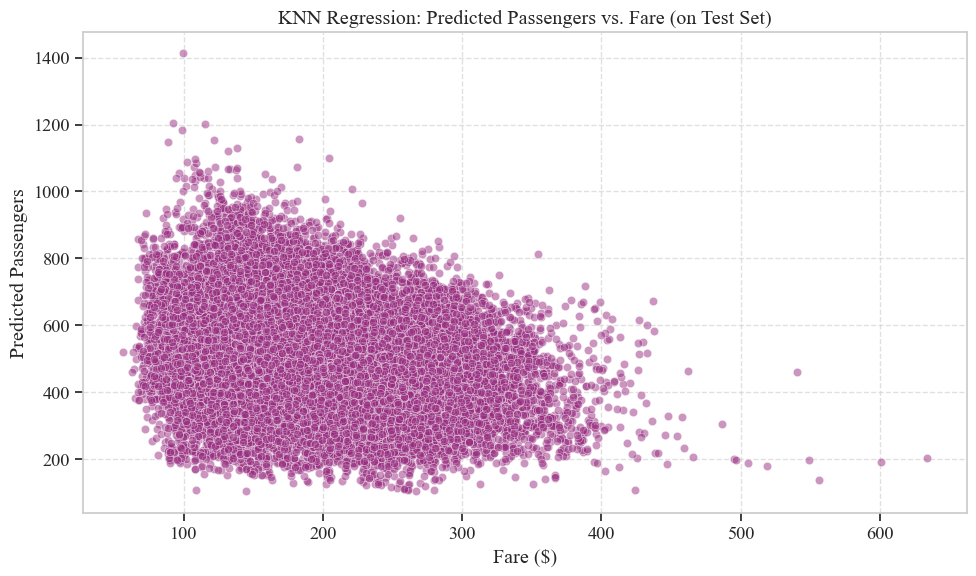

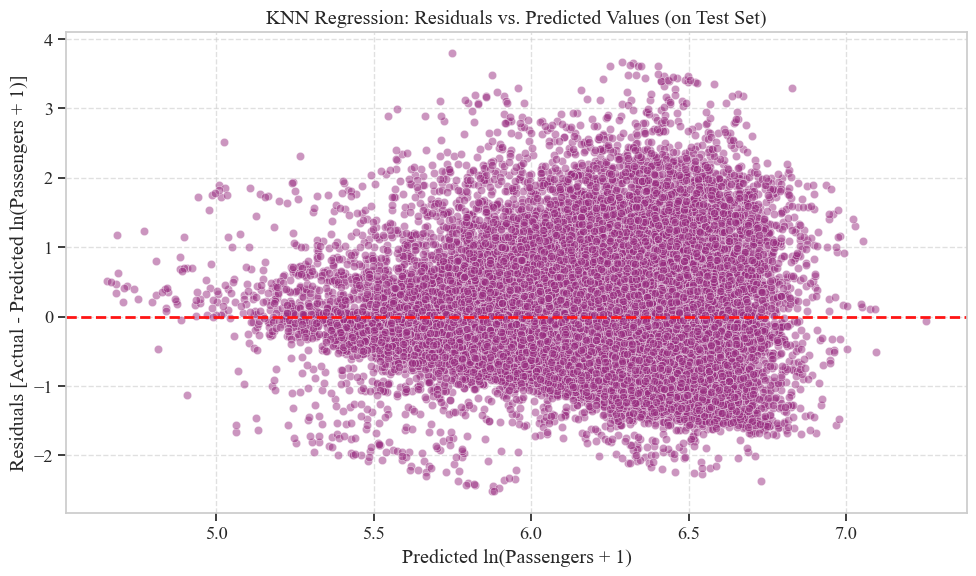

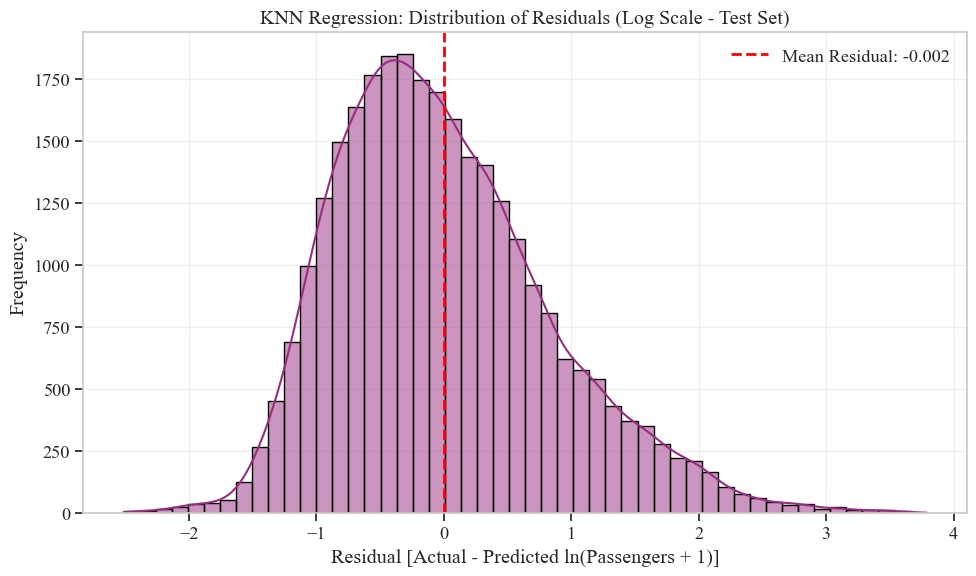

In [49]:
print(f"Generating plots for {method}...")
y_pred_lr = np.expm1(y_pred_log_lr)
y_test_o = np.expm1(y_test) 
plot_forecast_vs_price(y_pred_lr, df_model.loc[X_test.index, 'fare'], method)
plot_residuals(y_test, y_pred_log_lr, method)
plot_residual_distribution(y_test, y_pred_log_lr, method)
# plot_actual_vs_predicted(y_test, y_pred_lr, method)
plot_actual_vs_predicted_plotly(y_test_o, y_pred_lr, method)

#### 3.2. Ridge Regression

In [50]:
method = "Ridge Regression"
print(f"\n--- Processing Model: {method} ---")
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0))]) # adjust alpha if needed
print(f"Training {method}...")
pipeline_ridge.fit(X_train, y_train)
trained_pipelines[method] = pipeline_ridge

print(f"Predicting with {method}...")
y_pred_log_ridge = pipeline_ridge.predict(X_test)
display(pd.DataFrame(y_pred_log_ridge))


--- Processing Model: Ridge Regression ---
Training Ridge Regression...
Predicting with Ridge Regression...


0
0      5.893507
1      6.357076
2      6.448906
3      6.453850
4      6.459451
...         ...
28753  6.234494
28754  6.570118
28755  6.598656
28756  5.995166
28757  5.884341

[28758 rows x 1 columns]

In [22]:
calculate_metrics(error_df, method, y_test, y_pred_log_ridge)
display(error_df)
calculate_cross_validation_scores(cv_df, pipeline_ridge, method, X, y, cv=5)
display(cv_df)

MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression        542.71068  0.673265  0.723772  1301.974113  0.850748   
ElasticNet Regression         NaN       NaN       NaN          NaN       NaN   
Random Forest                 NaN       NaN       NaN          NaN       NaN   
XGBoost                       NaN       NaN       NaN          NaN       NaN   
KNN Regression                NaN       NaN       NaN          NaN       NaN   

                         R2_log  
Linear Regression      0.122923  
Ridge Regression       0.122924  
ElasticNet Regression       NaN  
Random Forest               NaN  
XGBoost                     NaN  
KNN Regression              NaN

MAE_log   MSE_log  RMSE_log    R2_log
Linear Regression      0.832415  4.084265  1.563203 -3.939456
Ridge Regression       0.832406  4.083939  1.563161 -3.939062
ElasticNet Regression       NaN       NaN       NaN       NaN
Random Forest               NaN       NaN       NaN       NaN
XGBoost                     NaN       NaN       NaN       NaN
KNN Regression              NaN       NaN       NaN       NaN

Generating plots for Ridge Regression...


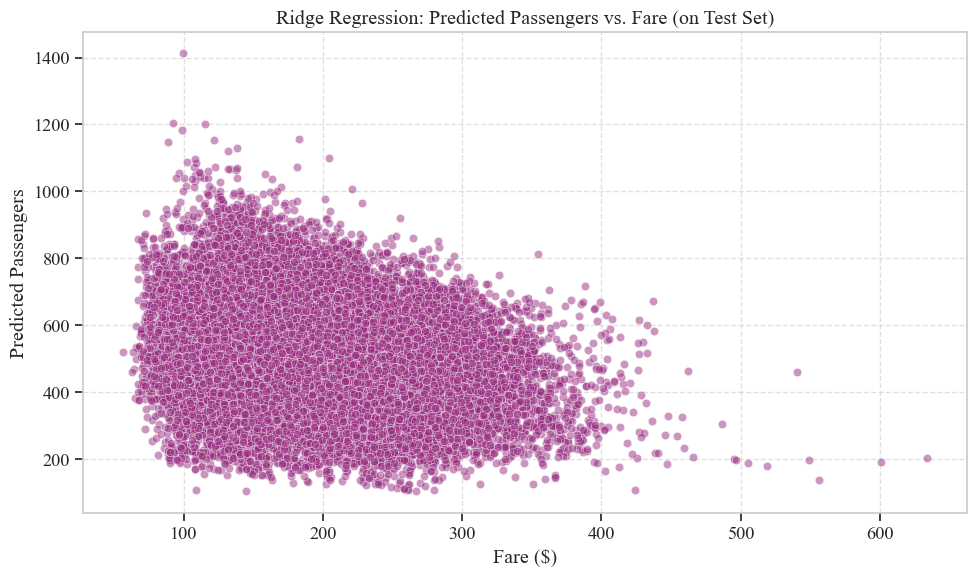

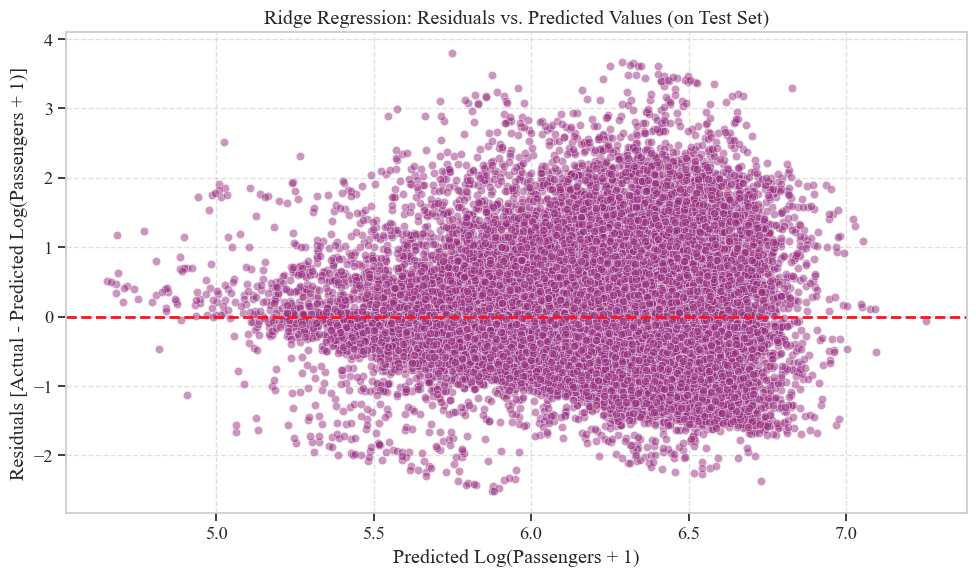

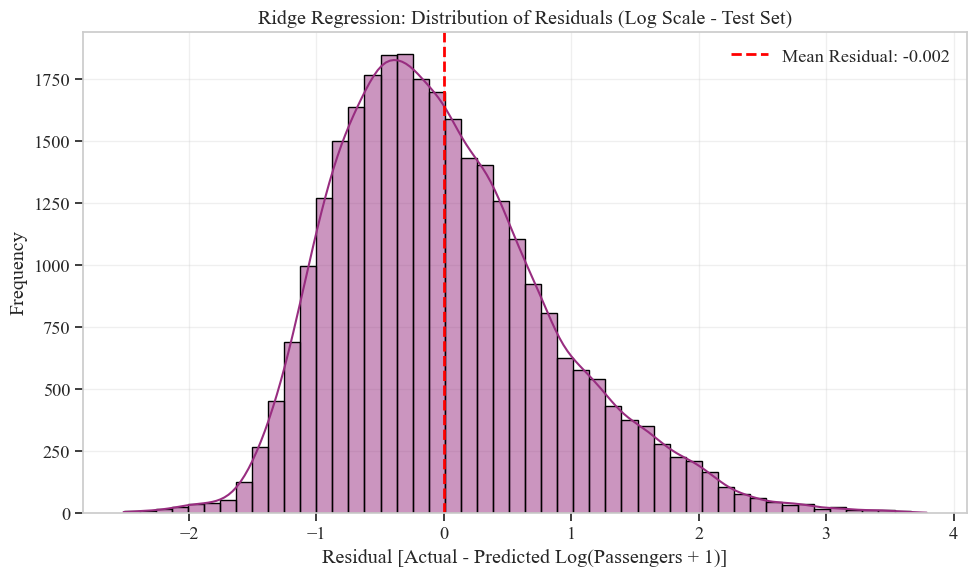

In [23]:
print(f"Generating plots for {method}...")
y_pred_ridge = np.expm1(y_pred_log_ridge)
# y_test_o = np.expm1(y_test) 
plot_forecast_vs_price(y_pred_ridge, df_model.loc[X_test.index, 'fare'], method)
plot_residuals(y_test, y_pred_log_ridge, method)
plot_residual_distribution(y_test, y_pred_log_ridge, method)
plot_actual_vs_predicted_plotly(y_test_o, y_pred_ridge, method)

#### 3.3. ElasticNet Regression

In [51]:
method = "ElasticNet Regression"
print(f"\n--- Processing Model: {method} ---")
pipeline_enet = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet(alpha=1.0))]) # adjust alpha if needed
print(f"Training {method}...")
pipeline_enet.fit(X_train, y_train)
trained_pipelines[method] = pipeline_enet

print(f"Predicting with {method}...")
y_pred_log_enet = pipeline_enet.predict(X_test)
display(pd.DataFrame(y_pred_log_enet))


--- Processing Model: ElasticNet Regression ---
Training ElasticNet Regression...
Predicting with ElasticNet Regression...


0
0      6.186148
1      6.186148
2      6.186148
3      6.186148
4      6.186148
...         ...
28753  6.186148
28754  6.186148
28755  6.186148
28756  6.186148
28757  6.186148

[28758 rows x 1 columns]

In [25]:
calculate_metrics(error_df, method, y_test, y_pred_log_enet)
display(error_df)
calculate_cross_validation_scores(cv_df, pipeline_enet, method, X, y, cv=5)
display(cv_df)

MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression        542.71068  0.673265  0.723772  1301.974113  0.850748   
ElasticNet Regression  565.630245  0.726473   0.82521  1335.463839  0.908411   
Random Forest                 NaN       NaN       NaN          NaN       NaN   
XGBoost                       NaN       NaN       NaN          NaN       NaN   
KNN Regression                NaN       NaN       NaN          NaN       NaN   

                         R2_log  
Linear Regression      0.122923  
Ridge Regression       0.122924  
ElasticNet Regression      -0.0  
Random Forest               NaN  
XGBoost                     NaN  
KNN Regression              NaN

MAE_log   MSE_log  RMSE_log    R2_log
Linear Regression      0.832415  4.084265  1.563203 -3.939456
Ridge Regression       0.832406  4.083939  1.563161 -3.939062
ElasticNet Regression  0.733032   0.84109  0.915739 -0.013423
Random Forest               NaN       NaN       NaN       NaN
XGBoost                     NaN       NaN       NaN       NaN
KNN Regression              NaN       NaN       NaN       NaN

Generating plots for ElasticNet Regression...


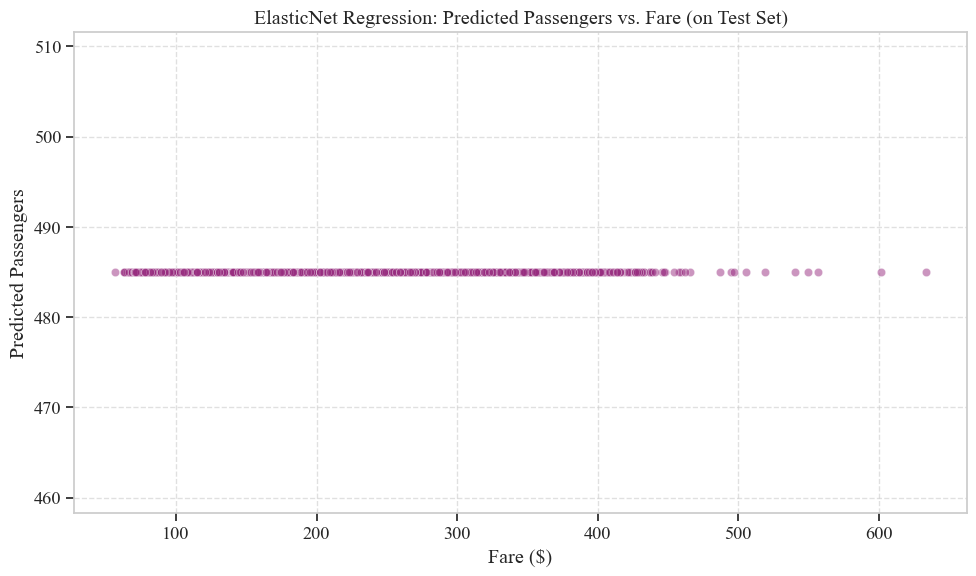

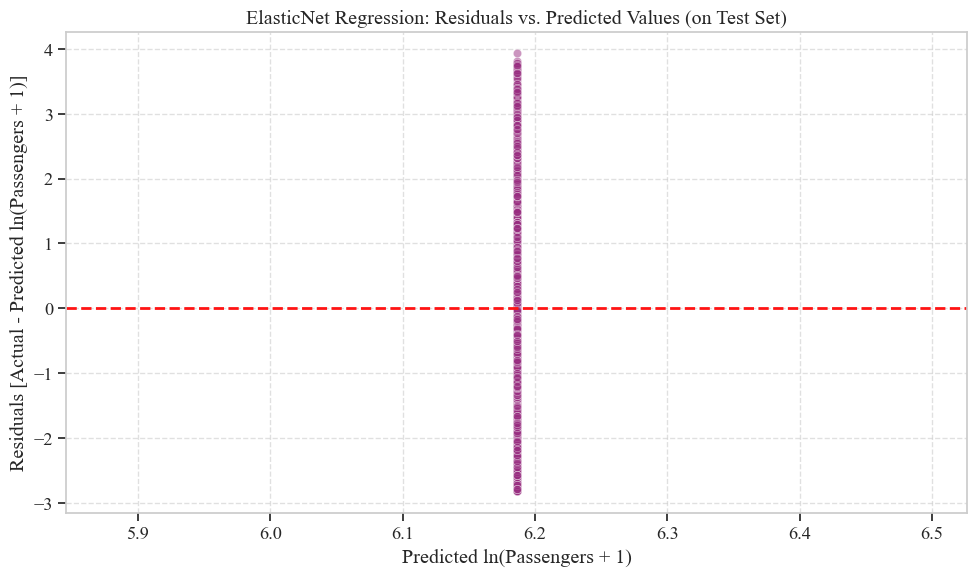

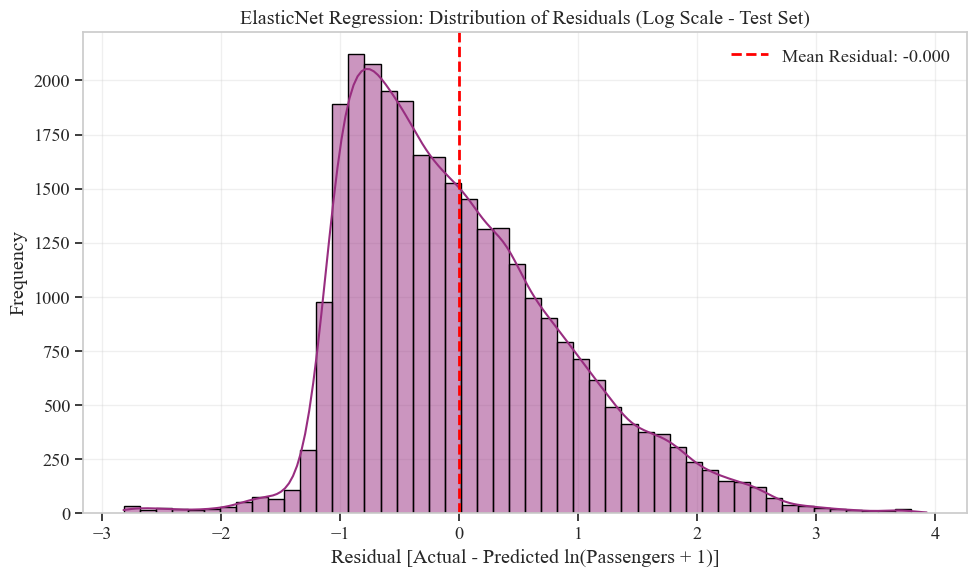

In [52]:
print(f"Generating plots for {method}...")
y_pred_enet = np.expm1(y_pred_log_enet)
# y_test_o = np.expm1(y_test) 
plot_forecast_vs_price(y_pred_enet, df_model.loc[X_test.index, 'fare'], method)
plot_residuals(y_test, y_pred_log_enet, method)
plot_residual_distribution(y_test, y_pred_log_enet, method)
plot_actual_vs_predicted_plotly(y_test_o, y_pred_enet, method)

#### 3.4. Random Forest

In [27]:
method = "Random Forest"
print(f"\n--- Processing Model: {method} ---")
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
                                                                max_depth=15, min_samples_leaf=10))])
print(f"Training {method}...")
pipeline_rf.fit(X_train, y_train)
trained_pipelines[method] = pipeline_rf
print(f"Predicting with {method}...")
y_pred_log_rf = pipeline_rf.predict(X_test)
display(pd.DataFrame(y_pred_log_rf))


--- Processing Model: Random Forest ---
Training Random Forest...
Predicting with Random Forest...


0
0      5.482836
1      6.043638
2      6.073379
3      6.067432
4      6.191547
...         ...
28753  5.916232
28754  6.619146
28755  6.789274
28756  5.775153
28757  5.372448

[28758 rows x 1 columns]

In [28]:
calculate_metrics(error_df, method, y_test, y_pred_log_rf)
display(error_df)
calculate_cross_validation_scores(cv_df, pipeline_rf, method, X, y, cv=5)
display(cv_df)

MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression        542.71068  0.673265  0.723772  1301.974113  0.850748   
ElasticNet Regression  565.630245  0.726473   0.82521  1335.463839  0.908411   
Random Forest          366.191397  0.433756  0.323506   871.224232  0.568776   
XGBoost                       NaN       NaN       NaN          NaN       NaN   
KNN Regression                NaN       NaN       NaN          NaN       NaN   

                         R2_log  
Linear Regression      0.122923  
Ridge Regression       0.122924  
ElasticNet Regression      -0.0  
Random Forest          0.607972  
XGBoost                     NaN  
KNN Regression              NaN

MAE_log   MSE_log  RMSE_log    R2_log
Linear Regression      0.832415  4.084265  1.563203 -3.939456
Ridge Regression       0.832406  4.083939  1.563161 -3.939062
ElasticNet Regression  0.733032   0.84109  0.915739 -0.013423
Random Forest          0.551459  0.544707  0.734464   0.34587
XGBoost                     NaN       NaN       NaN       NaN
KNN Regression              NaN       NaN       NaN       NaN

Generating plots for ElasticNet Regression...


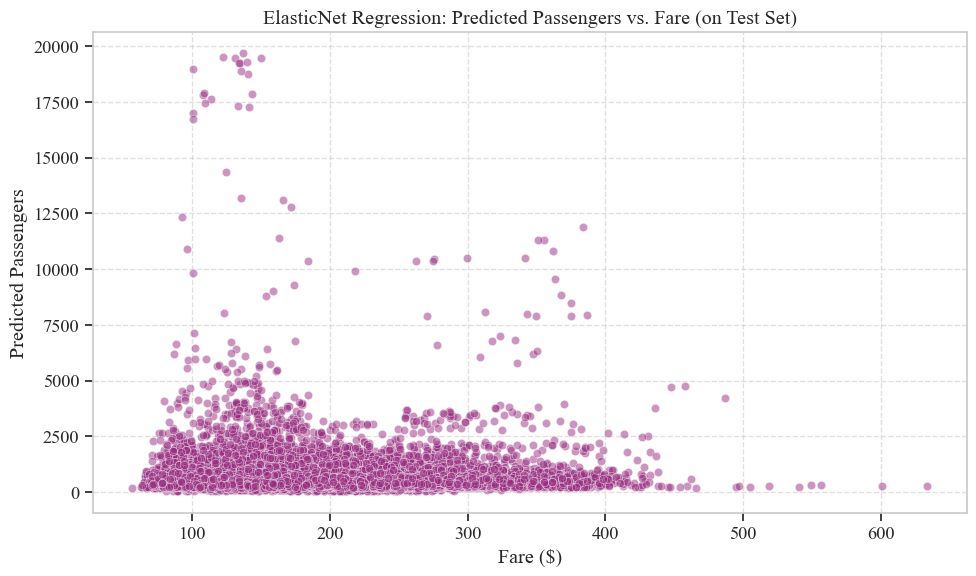

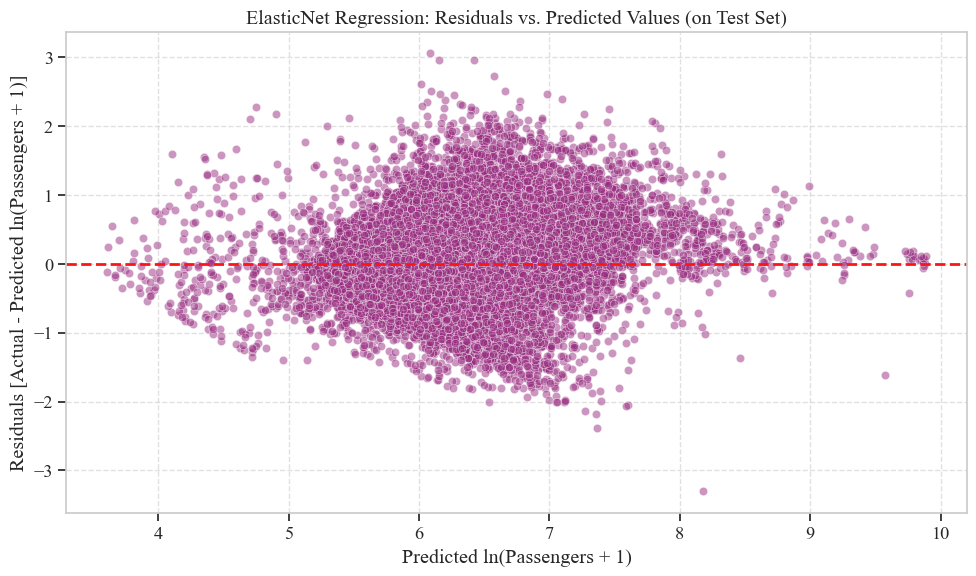

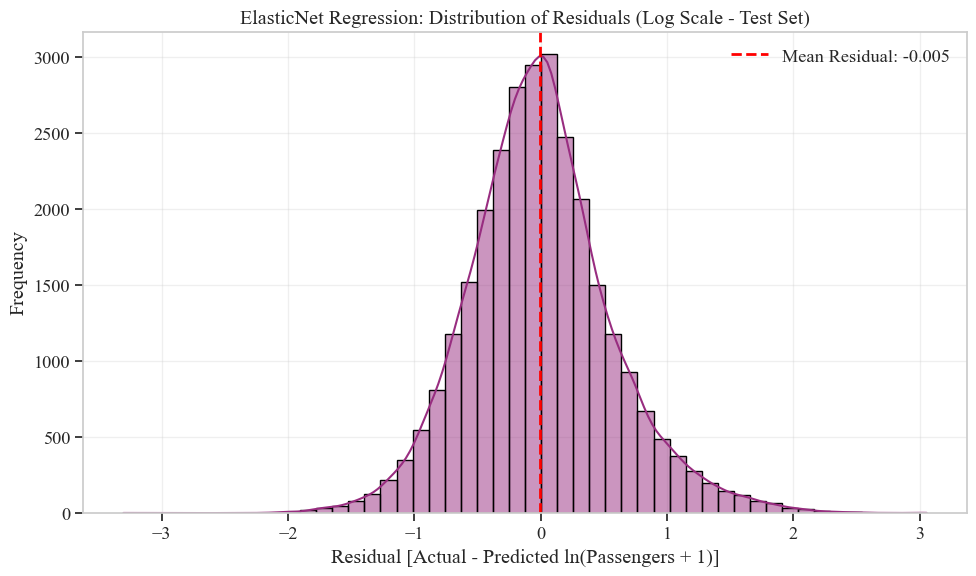

In [53]:
print(f"Generating plots for {method}...")
y_pred_rf = np.expm1(y_pred_log_rf)
# y_test_o = np.expm1(y_test) 
plot_forecast_vs_price(y_pred_rf, df_model.loc[X_test.index, 'fare'], method)
plot_residuals(y_test, y_pred_log_rf, method)
plot_residual_distribution(y_test, y_pred_log_rf, method)
# plot_actual_vs_predicted(y_test, y_pred_rf, method)
plot_actual_vs_predicted_plotly(y_test_o, y_pred_rf, method)

#### 3.6. XGBoost

In [30]:
method = "XGBoost"
print(f"\n--- Processing Model: {method} ---")
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb_model)])
print(f"Training {methods}...")
pipeline_xgb.fit(X_train, y_train)
trained_pipelines[method] = pipeline_xgb
print(f"Predicting with {method}...")
y_pred_log_xgb = pipeline_xgb.predict(X_test)
display(pd.DataFrame(y_pred_log_xgb))


--- Processing Model: XGBoost ---
Training ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression', 'Random Forest', 'XGBoost', 'KNN Regression']...
Predicting with XGBoost...


0
0      5.609326
1      6.279442
2      6.112438
3      6.263685
4      5.925515
...         ...
28753  5.889328
28754  6.577759
28755  6.911944
28756  5.469535
28757  5.721356

[28758 rows x 1 columns]

In [31]:
calculate_metrics(error_df, method, y_test, y_pred_log_xgb)
display(error_df)
calculate_cross_validation_scores(cv_df, pipeline_xgb, method, X, y, cv=5)
display(cv_df)

MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression        542.71068  0.673265  0.723772  1301.974113  0.850748   
ElasticNet Regression  565.630245  0.726473   0.82521  1335.463839  0.908411   
Random Forest          366.191397  0.433756  0.323506   871.224232  0.568776   
XGBoost                386.519958  0.446083  0.325996   974.854086  0.570961   
KNN Regression                NaN       NaN       NaN          NaN       NaN   

                         R2_log  
Linear Regression      0.122923  
Ridge Regression       0.122924  
ElasticNet Regression      -0.0  
Random Forest          0.607972  
XGBoost                0.604953  
KNN Regression              NaN

MAE_log   MSE_log  RMSE_log    R2_log
Linear Regression      0.832415  4.084265  1.563203 -3.939456
Ridge Regression       0.832406  4.083939  1.563161 -3.939062
ElasticNet Regression  0.733032   0.84109  0.915739 -0.013423
Random Forest          0.551459  0.544707  0.734464   0.34587
XGBoost                0.543766  0.507985  0.709054  0.390081
KNN Regression              NaN       NaN       NaN       NaN

Generating plots for ElasticNet Regression...


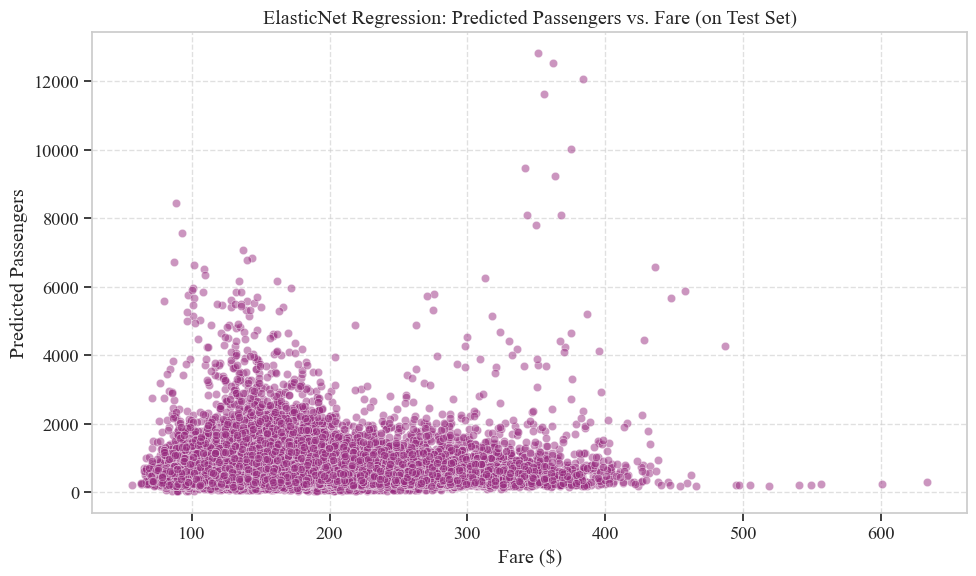

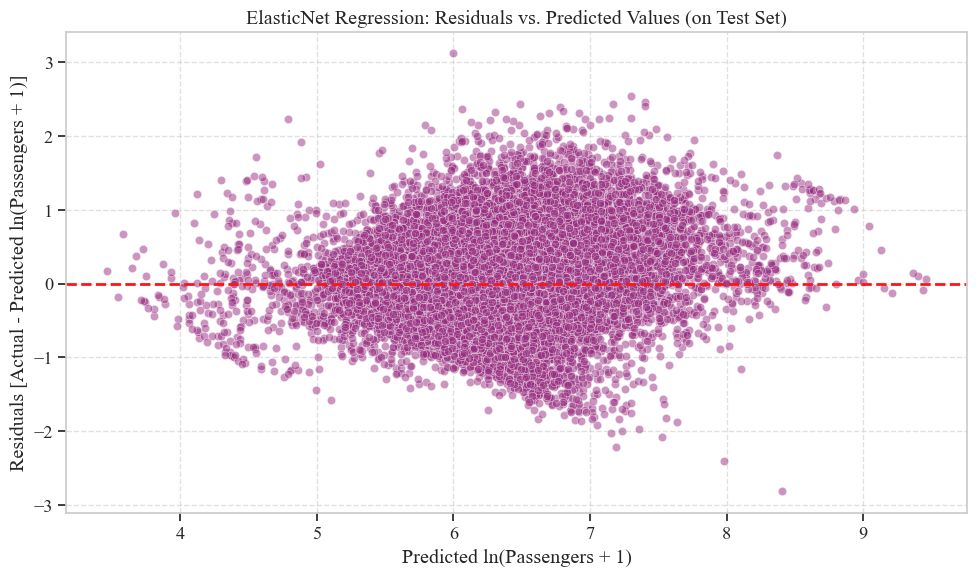

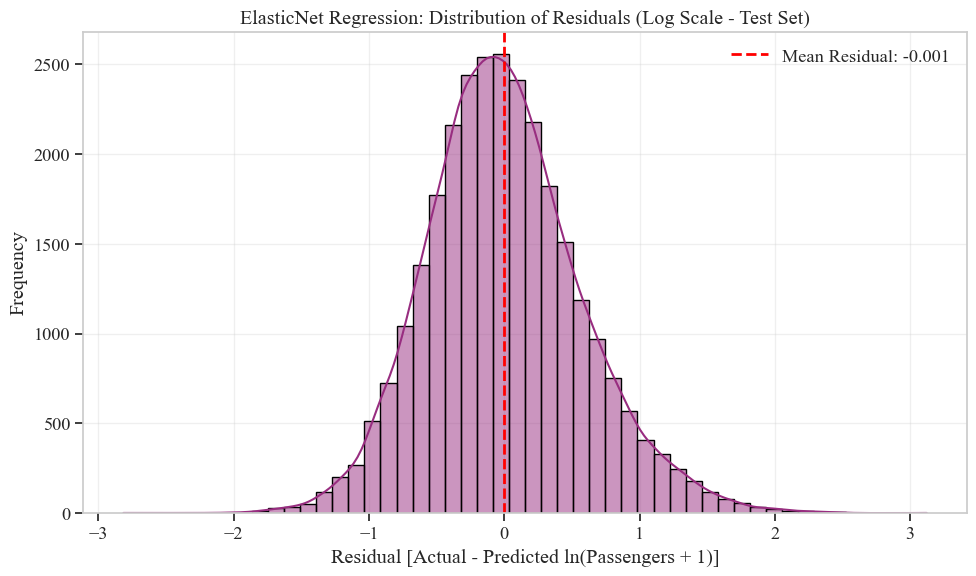

In [54]:
print(f"Generating plots for {method}...")
y_pred_xgb = np.expm1(y_pred_log_xgb)
plot_forecast_vs_price(y_pred_xgb, df_model.loc[X_test.index, 'fare'], method)
plot_residuals(y_test, y_pred_log_xgb, method)
plot_residual_distribution(y_test, y_pred_log_xgb, method)
# plot_actual_vs_predicted(y_test_o, y_pred_xgb, method)
plot_actual_vs_predicted_plotly(y_test_o, y_pred_xgb, method)

#### 3.7. KNN Regression

In [33]:
method = "KNN Regression"
print(f"\n--- Processing Model: {method} ---")
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', KNeighborsRegressor(n_neighbors=10))]) # adjust n_neighbors
print(f"Training {method}...")
pipeline_knn.fit(X_train, y_train) 
trained_pipelines[method] = pipeline_knn
print(f"Predicting with {method}...")
y_pred_log_knn = pipeline_knn.predict(X_test)
display(pd.DataFrame(y_pred_log_knn))


--- Processing Model: KNN Regression ---
Training KNN Regression...
Predicting with KNN Regression...


0
0      6.040187
1      6.372362
2      5.802955
3      6.398876
4      6.699266
...         ...
28753  6.821218
28754  6.897176
28755  6.612225
28756  5.715913
28757  5.660240

[28758 rows x 1 columns]

In [34]:
calculate_metrics(error_df, method, y_test, y_pred_log_knn)
display(error_df)
calculate_cross_validation_scores(cv_df, pipeline_knn, method, X, y, cv=5)
display(cv_df)

MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression        542.71068  0.673265  0.723772  1301.974113  0.850748   
ElasticNet Regression  565.630245  0.726473   0.82521  1335.463839  0.908411   
Random Forest          366.191397  0.433756  0.323506   871.224232  0.568776   
XGBoost                386.519958  0.446083  0.325996   974.854086  0.570961   
KNN Regression         472.121211  0.545505  0.502119  1168.537606  0.708604   

                         R2_log  
Linear Regression      0.122923  
Ridge Regression       0.122924  
ElasticNet Regression      -0.0  
Random Forest          0.607972  
XGBoost                0.604953  
KNN Regression         0.391525

MAE_log   MSE_log  RMSE_log    R2_log
Linear Regression      0.832415  4.084265  1.563203 -3.939456
Ridge Regression       0.832406  4.083939  1.563161 -3.939062
ElasticNet Regression  0.733032   0.84109  0.915739 -0.013423
Random Forest          0.551459  0.544707  0.734464   0.34587
XGBoost                0.543766  0.507985  0.709054  0.390081
KNN Regression          0.61029  0.634182  0.794266  0.236491

Generating plots for ElasticNet Regression...


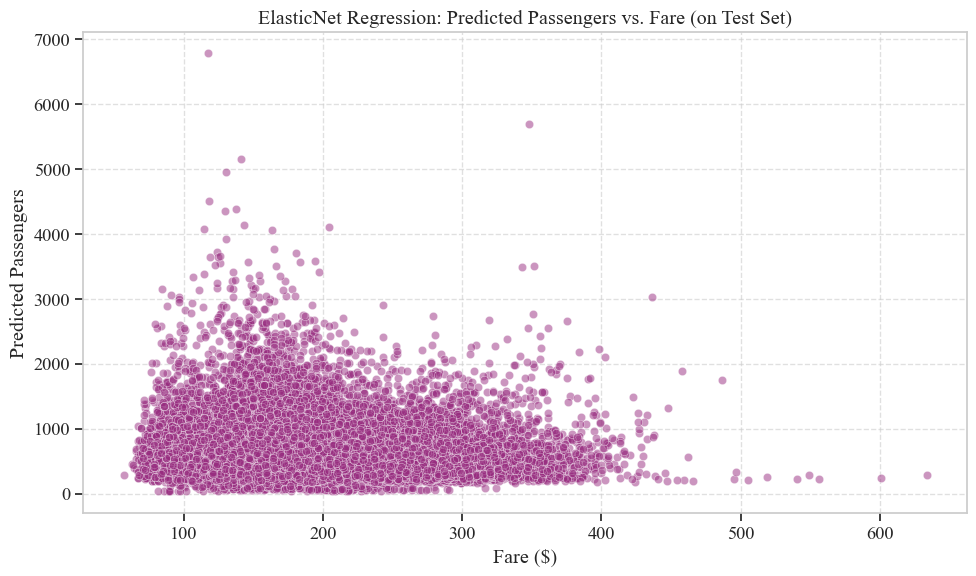

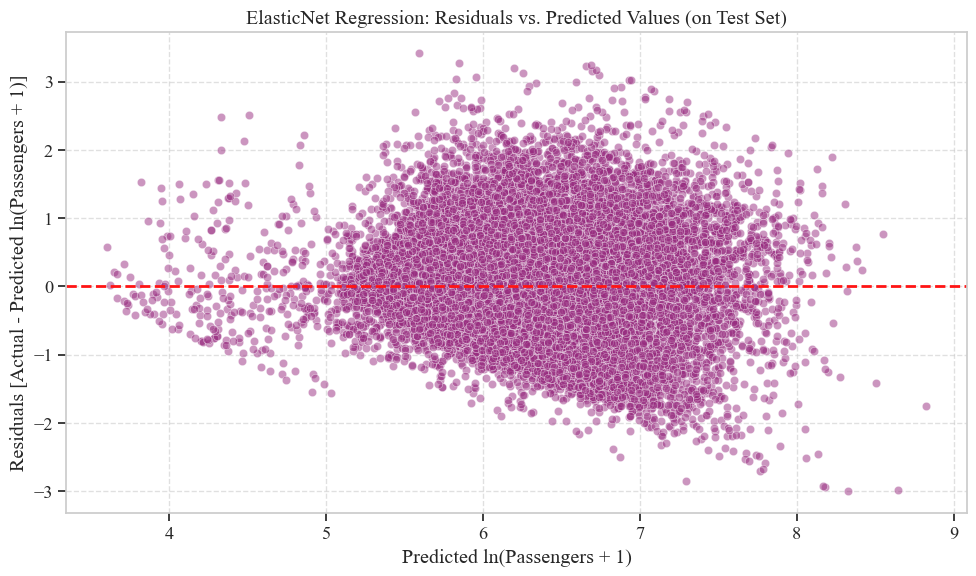

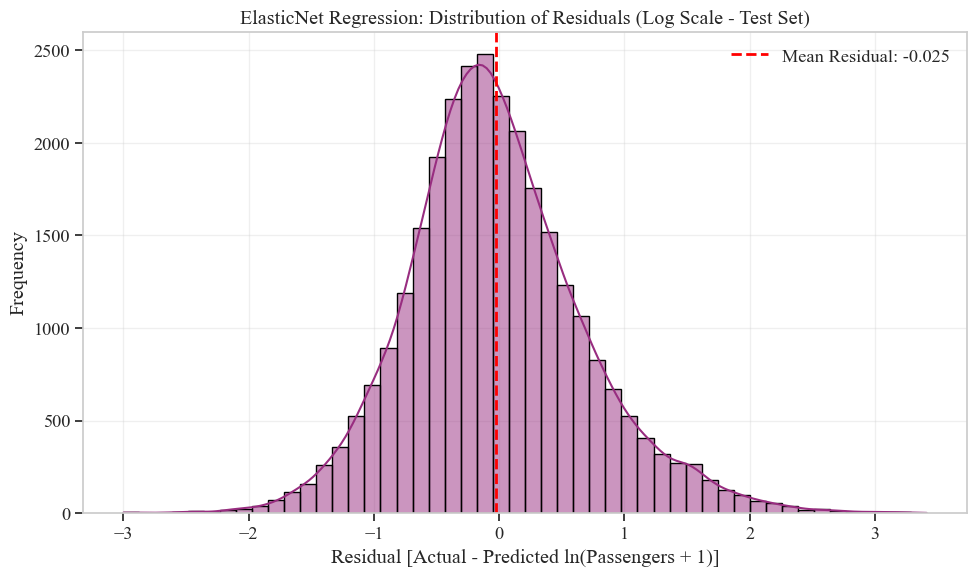

In [55]:
print(f"Generating plots for {method}...")
y_pred_knn = np.expm1(y_pred_log_knn)
plot_forecast_vs_price(y_pred_knn, df_model.loc[X_test.index, 'fare'], method)
plot_residuals(y_test, y_pred_log_knn, method)
plot_residual_distribution(y_test, y_pred_log_knn, method)
# plot_actual_vs_predicted(y_test_o, y_pred_knn, method)
plot_actual_vs_predicted_plotly(y_test_o, y_pred_knn, method)

### 4. Prediction Model Evaluation

In [36]:
min_cv_metric = 'RMSE_log'
best_model = cv_df[min_cv_metric].idxmin()
best_model_score = cv_df.loc[best_model, min_cv_metric]
print(f"Identifying best model based on minimizing CV '{min_cv_metric}':")
print(f"\nBest Model: '{best_model}'")

print("\nFull Cross-Validation Results (Sorted by RMSE_log):")
display(cv_df.sort_values(by=min_cv_metric))

best_model_test_rmse_orig = error_df['RMSE'].idxmin()
print(f"\nBest model based on Test Set 'RMSE' was '{best_model_test_rmse_orig}' (RMSE: {error_df.loc[best_model_test_rmse_orig, 'RMSE']:.2f})")

print("\nTest Set Performance (Sorted by RMSE):")
display(error_df.sort_values(by='RMSE'))

Identifying best model based on minimizing CV 'RMSE_log':

Best Model: 'XGBoost'

Full Cross-Validation Results (Sorted by RMSE_log):


MAE_log   MSE_log  RMSE_log    R2_log
XGBoost                0.543766  0.507985  0.709054  0.390081
Random Forest          0.551459  0.544707  0.734464   0.34587
KNN Regression          0.61029  0.634182  0.794266  0.236491
ElasticNet Regression  0.733032   0.84109  0.915739 -0.013423
Ridge Regression       0.832406  4.083939  1.563161 -3.939062
Linear Regression      0.832415  4.084265  1.563203 -3.939456


Best model based on Test Set 'RMSE' was 'Random Forest' (RMSE: 871.22)

Test Set Performance (Sorted by RMSE):


MAE   MAE_log   MSE_log         RMSE  RMSE_log  \
Random Forest          366.191397  0.433756  0.323506   871.224232  0.568776   
XGBoost                386.519958  0.446083  0.325996   974.854086  0.570961   
KNN Regression         472.121211  0.545505  0.502119  1168.537606  0.708604   
Linear Regression      542.711018  0.673266  0.723772  1301.972746  0.850748   
Ridge Regression        542.71068  0.673265  0.723772  1301.974113  0.850748   
ElasticNet Regression  565.630245  0.726473   0.82521  1335.463839  0.908411   

                         R2_log  
Random Forest          0.607972  
XGBoost                0.604953  
KNN Regression         0.391525  
Linear Regression      0.122923  
Ridge Regression       0.122924  
ElasticNet Regression      -0.0

### 5. Feature Importance

In [56]:
def plot_feature_importance(pipeline, input_feature_names, top_n=20):
    """
    Extracts and plots feature importance or coefficients from a scikit-learn pipeline.
    Prioritizes using get_feature_names_out from the preprocessor step.
    """
    # --- Get Model and Preprocessor ---
    preprocessor = pipeline.named_steps.get('preprocessor')
    regressor = pipeline.named_steps.get('regressor')
    if preprocessor is None or regressor is None:
        print("Error: Pipeline steps 'preprocessor' or 'regressor' not found.")
        return
    model_display_name = type(regressor).__name__
    

    print(f"\n--- Feature Importance/Coefficients for {model_display_name} ---")

    # --- Get Feature Names after Preprocessing ---
    feature_names_out = None

    # Use get_feature_names_out on the preprocessor
    feature_names_out = preprocessor.get_feature_names_out(input_feature_names)
    print(f"Successfully extracted {len(feature_names_out)} feature names using get_feature_names_out.")

    feature_labels = [label_map.get(f) for f in feature_names_out] # map to readable labels if possible
    feature_names_out = feature_labels
    
    # --- Plot based on available attribute ---
    plotted = False
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        if len(feature_names_out) == len(importances):
            importance_df = pd.DataFrame({'feature': feature_names_out, 'importance': importances})
            importance_df = importance_df.sort_values('importance', ascending=False).head(top_n)
            
            plt.figure(figsize=(10, max(5, len(importance_df) * 0.4))) 
            
            sns.barplot(data=importance_df, 
                        x='importance', 
                        y='feature', 
                        legend=False, 
                        hue='feature', 
                        palette='magma')
            
            plt.title(f'Top {top_n} Feature Importances ({model_display_name})')
            plt.xlabel('Importance Score')
            plt.ylabel('Feature')
            plt.tight_layout()
            
            plt.savefig(f'../outputs/R_TML_feature_importance_{model_display_name}.pdf', format='pdf', bbox_inches='tight', transparent=True)
            plt.show()
            plotted = True
        else: print(f"Error: Mismatch between feature names ({len(feature_names_out)}) and importances ({len(importances)}).")

    elif hasattr(regressor, 'coef_'):
        coefficients = regressor.coef_
        if coefficients.ndim > 1: coefficients = coefficients.flatten()
        
        if len(feature_names_out) == len(coefficients):
            coef_df = pd.DataFrame({'feature': feature_names_out, 'coefficient': coefficients})
            coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
            coef_df = coef_df.sort_values('abs_coefficient', ascending=False).head(top_n)
            
            plt.figure(figsize=(10, max(5, len(coef_df) * 0.4))) 
            plot_color = sns.color_palette("viridis")[3]
            
            # Plot actual coefficients to see direction
            sns.barplot(data=coef_df.sort_values('coefficient', ascending=False), 
                        x='coefficient', 
                        y='feature', 
                        color=plot_color)
            
            plt.title(f'Top {top_n} Feature Coefficients by Absolute Value ({model_display_name})')
            plt.xlabel('Coefficient Value (Impact on log_passengers)')
            plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
            plt.ylabel('Feature')
            plt.tight_layout()
            
            plt.savefig(f'../outputs/R_TML_feature_coefficients_{model_display_name}.pdf', format='pdf', bbox_inches='tight', transparent=True)
            plt.show()
            plotted = True
        else: print(f"Error: Mismatch between feature names ({len(feature_names_out)}) and coefficients ({len(coefficients)}).")


Generating feature importances for model: 'XGBoost'

--- Feature Importance/Coefficients for XGBRegressor ---
Successfully extracted 23 feature names using get_feature_names_out.


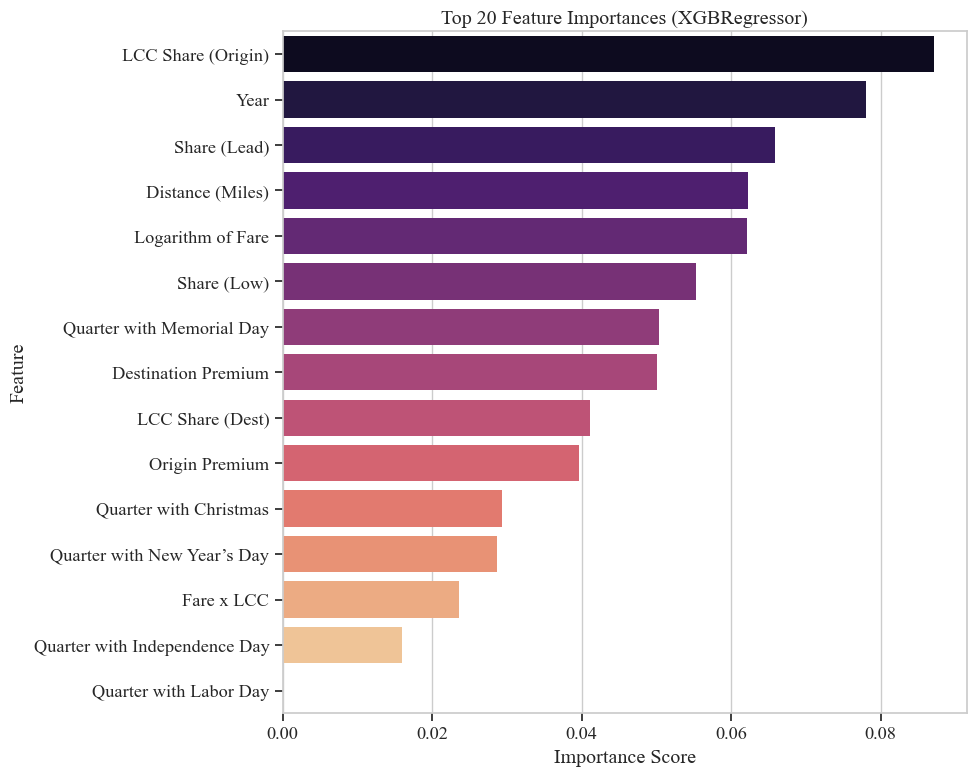

In [38]:
print(f"Generating feature importances for model: '{best_model}'")
best_model_pipeline = trained_pipelines[best_model]
input_features = X_train.columns.tolist()

plot_feature_importance(best_model_pipeline, input_features)

## Original Scale

In [39]:
def calculate_metrics_o(df, method, y_true, y_pred):
    """Calculates log-scale metrics & original-scale MAE, RMSE, and adds them to a DataFrame."""
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)    
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    df.loc[method] = [mae, mse, rmse, r2]
    

def calculate_cross_validation_scores_o(df, model, method, X, y, cv=5):
    """Calculates cross-validated metrics on log scale"""
    # Use negative scores because cross_val_score maximizes utility (so minimizes neg error)
    mae_cv = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv).mean()
    mse_cv = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv).mean()
    rmse_cv = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv).mean()
    r2_cv = cross_val_score(model, X, y, scoring='r2', cv=cv).mean()
    df.loc[method] = [mae_cv, mse_cv, rmse_cv, r2_cv]

In [40]:
TARGET_ORIG = 'passengers'
FEATURES_ORIG = [
    'fare',
    'nsmiles',
    'large_ms',
    'lf_ms',
    'origin_fare_premium',
    'origin_perc_lcc_pax',
    'dest_fare_premium',
    'dest_perc_lcc_pax',
    'Year', 
    'Q_2', 'Q_3', 'Q_4' 
    'lg_carrier_is_lcc', 
    'carrier_lg',
    'is_Q_with_NYD', 
    'is_Q_with_Memorial', 
    'is_Q_with_Jul4_Indep', 
    'is_Q_with_Labor', 
    'is_Q_with_Christmas', 
    'fare_x_is_lcc'
]

FEATURES_ORIG = [f for f in FEATURES_ORIG if f in df_model.columns] 

In [41]:
df_model_orig = df_model[list(set([TARGET_ORIG] + FEATURES_ORIG))].copy() 

# --- Define features (X) and target (y) for original scale ---
X_orig = df_model_orig[FEATURES_ORIG] 
y_orig = df_model_orig[TARGET_ORIG].astype(float)

In [42]:
# --- Split Data ---
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.25, random_state=42)

# --- Define Numerical Features to Scale ---
numerical_features_to_scale_orig = [
    'fare', 'nsmiles', 'large_ms', 'lf_ms', 
    'origin_fare_premium', 'origin_perc_lcc_pax',
    'dest_fare_premium', 'dest_perc_lcc_pax', 'Year', 'fare_x_is_lcc'
]
numerical_features_to_scale_orig = [f for f in numerical_features_to_scale_orig if f in X_orig.columns]

In [43]:
preprocessor_orig = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features_to_scale_orig)],
    remainder='passthrough'
)

In [44]:
methods_orig = ['Linear Regression', 'Ridge Regression', 'ElasticNet Regression', 'Random Forest', 'XGBoost', 'KNN Regression']

error_o_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R2'], index=methods_orig)
display(error_o_df)
cv_o_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R2'], index=methods_orig)
display(cv_o_df)

MAE  MSE RMSE   R2
Linear Regression      NaN  NaN  NaN  NaN
Ridge Regression       NaN  NaN  NaN  NaN
ElasticNet Regression  NaN  NaN  NaN  NaN
Random Forest          NaN  NaN  NaN  NaN
XGBoost                NaN  NaN  NaN  NaN
KNN Regression         NaN  NaN  NaN  NaN

MAE  MSE RMSE   R2
Linear Regression      NaN  NaN  NaN  NaN
Ridge Regression       NaN  NaN  NaN  NaN
ElasticNet Regression  NaN  NaN  NaN  NaN
Random Forest          NaN  NaN  NaN  NaN
XGBoost                NaN  NaN  NaN  NaN
KNN Regression         NaN  NaN  NaN  NaN

In [45]:
models_orig = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "ElasticNet Regression": ElasticNet(alpha=1.0, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_leaf=10),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1, learning_rate=0.1, max_depth=7),
    "KNN Regression": KNeighborsRegressor(n_neighbors=10) # k=10
}
models_to_run = {name: model for name, model in models_orig.items() if name in methods_orig}

trained_pipelines_o = {}

for name, model in models_to_run.items():
    print(f"\n--- Processing Model (Original Scale): {name} ---")

    pipeline = Pipeline(steps=[('preprocessor', preprocessor_orig), ('regressor', model)])

    # Train
    print(f"Training {name}...")
    pipeline.fit(X_train_orig, y_train_orig)
    trained_pipelines_o[name] = pipeline

    # Predict on Test Set
    print(f"Predicting with {name} on test set...")
    y_pred_orig = pipeline.predict(X_test_orig)

    # Calculate and store Test metrics
    print(f"Calculating test metrics for {name}...")
    calculate_metrics_o(error_o_df, name, y_test_orig, y_pred_orig) 
    
    # Calculate and store cross-validation metrics
    print(f"Calculating CV metrics for {name} (using full original dataset)...")
    calculate_cross_validation_scores_o(cv_o_df, pipeline, name, X_orig, y_orig, cv=5)
    
display(error_o_df)
display(cv_o_df)


--- Processing Model (Original Scale): Linear Regression ---
Training Linear Regression...
Predicting with Linear Regression on test set...
Calculating test metrics for Linear Regression...
Calculating CV metrics for Linear Regression (using full original dataset)...

--- Processing Model (Original Scale): Ridge Regression ---
Training Ridge Regression...
Predicting with Ridge Regression on test set...
Calculating test metrics for Ridge Regression...
Calculating CV metrics for Ridge Regression (using full original dataset)...

--- Processing Model (Original Scale): ElasticNet Regression ---
Training ElasticNet Regression...
Predicting with ElasticNet Regression on test set...
Calculating test metrics for ElasticNet Regression...
Calculating CV metrics for ElasticNet Regression (using full original dataset)...

--- Processing Model (Original Scale): Random Forest ---
Training Random Forest...
Predicting with Random Forest on test set...
Calculating test metrics for Random Forest...
Cal

MAE             MSE         RMSE        R2
Linear Regression       645.36424  1590243.593808  1261.048609  0.052037
Ridge Regression        645.36379  1590243.555323  1261.048594  0.052037
ElasticNet Regression  644.204917  1601783.288916  1265.615775  0.045158
Random Forest          369.365509     497921.7767   705.635725  0.703183
XGBoost                401.801305   512939.632456    716.19804  0.694231
KNN Regression         520.720798  1117987.751867  1057.349399  0.333555

MAE             MSE         RMSE        R2
Linear Regression      773.026217  3709180.916083   1703.89957 -0.932297
Ridge Regression       773.020011   3708996.15678  1703.872521 -0.932211
ElasticNet Regression  686.854889  1899260.187769  1357.606013 -0.084804
Random Forest          454.520252   774235.206512   871.577089  0.547038
XGBoost                477.672813   818409.520048   898.106006  0.514221
KNN Regression         590.581126  1413048.007206  1187.237146  0.155414


--- Feature Importance for Best Original Scale Model: 'Random Forest' ---

--- Feature Importance/Coefficients for RandomForestRegressor ---
Successfully extracted 17 feature names using get_feature_names_out.


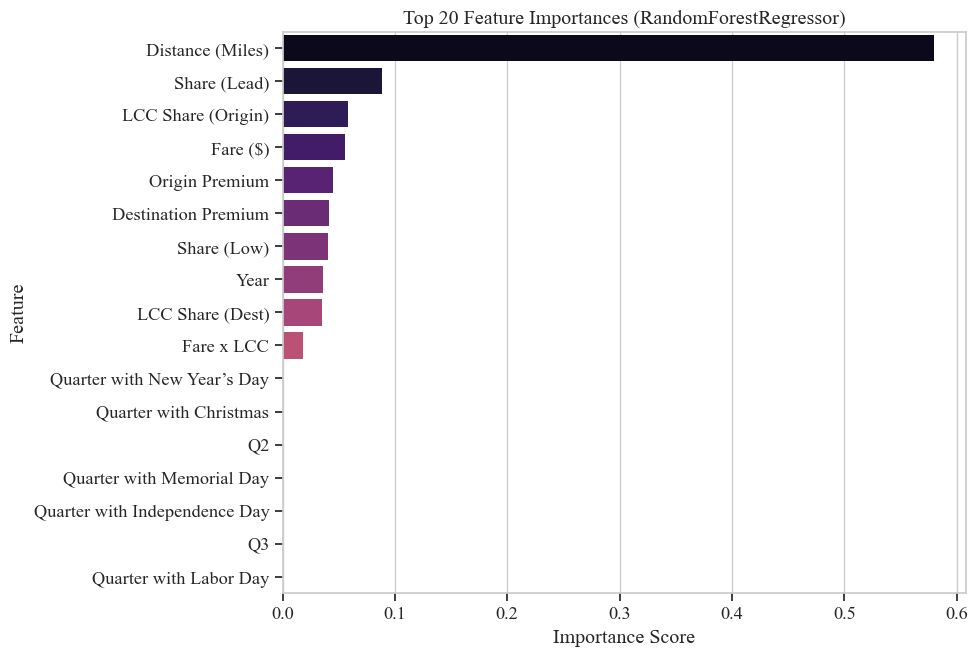

In [46]:
best_model_o = cv_o_df['RMSE'].idxmin()
print(f"\n--- Feature Importance for Best Original Scale Model: '{best_model_o}' ---")

best_pipeline_o = trained_pipelines_o[best_model_o]
input_features_o = X_train_orig.columns.tolist()
features_labels_o = [label_map.get(f) for f in input_features_o]


plot_feature_importance(best_pipeline_o, input_features_o)